In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import (
    dendrogram, fcluster, leaves_list, linkage)

%matplotlib inline

In [2]:
def quantile_norm(X):
    '''Normalize the columns of X to each have the same distribution.
    Given an expression matrix (microarray data, read counts, etc) of M
    genes by N samples, quantile normalization ensures all samples have the
    same spread of data by construction.
    The data across eac row are averaged to abtain an average column. Each
    column quantile is replaced with the corresponding quantile of the
    average column.

    Args:
    -----
    X (2D array<float> (M x N)): The input data, M genes/features, N samples

    Returns:
    --------
    Xn (2D array<float> (M x N)): Normalized data'''
    quantiles = np.mean(np.sort(X, axis=0), axis=1)
    # col-wise ranks
    ranks = np.apply_along_axis(stats.rankdata, 0, X)
    rank_indices = ranks.astype(int) - 1
    Xn = quantiles[rank_indices]
    return Xn

In [3]:
def quantile_norm_log(X):
    logX = np.log(X + 1)
    logXn = quantile_norm(logX)
    return logXn

In [4]:
!ls data

counts.txt   genes.csv    patients.csv


In [5]:
data = pd.read_csv('data/counts.txt', index_col=0)
data.head()

,00624286-41dd-476f-a63b-d2a5f484bb45,TCGA-FS-A1Z0,TCGA-D9-A3Z1,02c76d24-f1d2-4029-95b4-8be3bda8fdbe,TCGA-EB-A51B,TCGA-D3-A1Q3,TCGA-FR-A44A,TCGA-EE-A17Z,TCGA-D3-A51G,TCGA-D3-A51E,...,TCGA-D9-A149,TCGA-EE-A3AG,TCGA-D9-A4Z2,TCGA-EB-A4OZ,TCGA-EE-A3J4,TCGA-FS-A1ZM,TCGA-D3-A5GS,TCGA-EB-A3XF,TCGA-EE-A2GE,ff7431a9-243a-4651-80bb-096379925bbe
A1BG,1272.36,452.96,288.06,400.11,420.46,877.59,402.77,559.20,269.59,586.66,...,631.78,560.60,846.55,678.00,32.88,997.41,256.93,461.60,634.06,530.36
A1CF,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,4.00,3.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
A2BP1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00
A2LD1,164.38,552.43,201.83,165.12,95.75,636.63,241.56,30.82,105.44,239.19,...,218.47,274.45,770.04,71.74,17.00,194.26,156.81,84.35,242.01,377.03
A2ML1,27.00,0.00,0.00,0.00,8.00,0.00,1.00,763.00,0.00,0.00,...,3.00,6.00,0.00,1043.00,1.00,852.00,4.00,587.00,0.00,2.00


In [6]:
counts = data.values

In [7]:
def plot_col_density(data):
    '''For each column in <data>, produce a density plot over all rows'''
    density_per_col = [stats.gaussian_kde(col) for col in data.T]
    x = np.linspace(np.min(data), np.max(data), 100)
    fig, ax = plt.subplots()
    for density in density_per_col:
        ax.plot(x, density(x))
    ax.set_xlabel('Data values (per col)')
    ax.set_ylabel('Density')

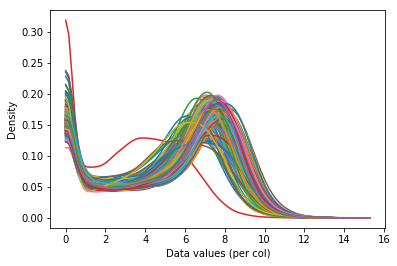

In [8]:
log_counts = np.log(counts + 1)
plot_col_density(log_counts)

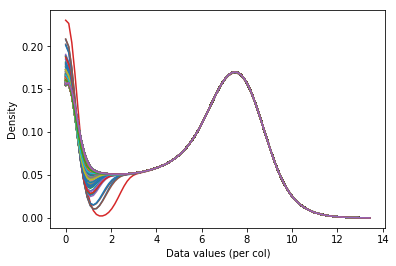

In [9]:
log_counts_normalized = quantile_norm_log(counts)
plot_col_density(log_counts_normalized)

In [10]:
def most_variable_rows(data, *, n=1500):
    '''Subset data to n most variable rows.  In this case, the n most
    variable genes.
    Args:
      data (2D array<float>): data to be subset
      n (int): number of rows to return
    Returns:
      variable_data (2D array<float>): the <n> rows of <data> that exhibit
        the greatest variation
    '''
    rowvar = np.var(data, axis=1)
    sort_indices = np.argsort(rowvar[-n:])
    variable_data = data[sort_indices, :]
    return variable_data

In [11]:
def bicluster(
        data, linkage_method='average', distance_metric='correlation'):
    '''Cluster the rows and columns of a matrix
    Args:
      data (2D array): input to bicluster
      linkage_method (str): linkage method for clustering
      distance_metric (str): distance method for clustering
    Returns:
      y_rows (linkage matrix): the clustering of rows in <data>
      y_cols (linkage matrix): the clustering of cols in <data>
    '''
    y_rows = linkage(data, method=linkage_method, metric=distance_metric)
    y_cols = linkage(data.T, method=linkage_method, metric=distance_metric)
    return y_rows, y_cols

In [12]:
def clear_spines(axes):
    for loc in ['left', 'right', 'top', 'bottom']:
        axes.spines[loc].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])

In [13]:
def plot_bicluster(
        data, row_linkage, col_linkage, row_ncluster=10, col_ncluster=3):
    '''Perform a biclustering, plot a heatmap with dendrograms on each axis
    Args:
    data (array<float>, shape (M, N)): The input data to bicluster.
    row_linkage (array, shape (M-1, 4)): The linkage matrix for the rows of
      <data>
    col_linkage (array, shape (N-1, 4)): The linkage matrix for the columns 
      of <data>
    row_nclusters, col_nclusters_c (int): Number of clusters for rows and 
      columns.
    '''
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
    threshold_r = (row_linkage[-row_ncluster, 2] 
                   + row_linkage[-row_ncluster + 1, 2]) / 2
    with plt.rc_context({'lines.linewidth': 0.75}):
        dendrogram(row_linkage, 
                   orientation='left', 
                   color_threshold=threshold_r, 
                   ax=ax1)
    clear_spines(ax1)
    ax2 = fig.add_axes([0.3, 0.71, 0.6, 0.2])
    threshold_c = (col_linkage[-col_ncluster, 2] 
                   + col_linkage[-col_ncluster + 1, 2]) / 2
    with plt.rc_context({'lines.linewidth': 0.75}):
        dendrogram(col_linkage, color_threshold=threshold_c, ax=ax2)
    clear_spines(ax2)
    # Col dendrogram
    ax = fig.add_axes([0.3, 0.1, 0.6, 0.6])
    idx_rows = leaves_list(row_linkage)
    data = data[idx_rows, :]
    idx_cols = leaves_list(col_linkage)
    data = data[:, idx_cols]
    im = ax.imshow(data, aspect='auto', origin='lower', cmap='YlGnBu_r')
    clear_spines(ax)
    ax.set_xlabel('Samples')
    ax.set_ylabel('Genes', labelpad=125)
    axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.6])
    plt.colorbar(im, cax=axcolor)
    plt.show()

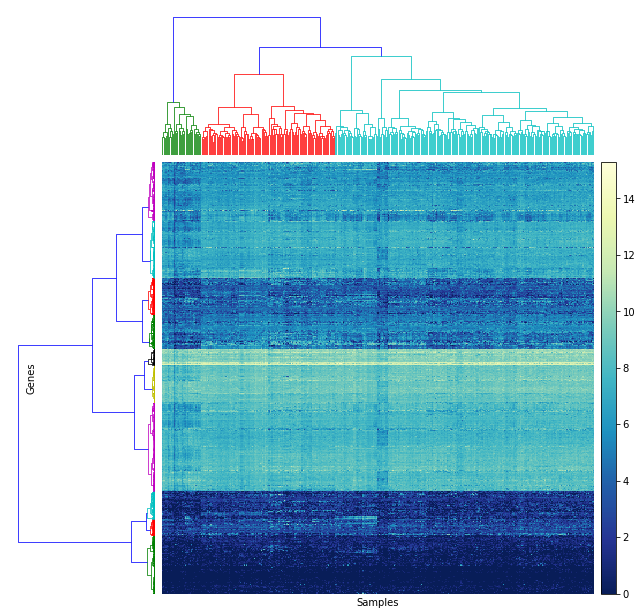

In [14]:
counts_log = np.log(counts + 1)
counts_var = most_variable_rows(counts_log, n=1500)
yr, yc = bicluster(
    counts_var, linkage_method='ward', distance_metric='euclidean')
plot_bicluster(counts_var, yr, yc)

In [15]:
patients = pd.read_csv('data/patients.csv', index_col=0)
patients.head()

,UV-signature,original-clusters,melanoma-survival-time,melanoma-dead
TCGA-BF-A1PU,UV signature,keratin,NaN,NaN
TCGA-BF-A1PV,UV signature,keratin,13.0,0.0
TCGA-BF-A1PX,UV signature,keratin,NaN,NaN
TCGA-BF-A1PZ,UV signature,keratin,NaN,NaN
TCGA-BF-A1Q0,not UV,immune,17.0,0.0


In [31]:
def survival_distribution_function(lifetimes, right_censored=None):
    '''Return the survival distribution function of a set of lifetimes.
    Args:
      lifetimes (array<float or int>)
        The observed lifetimes of a population. These must be non-negative.
      right_censored (array<bool>, same shape as <lifetimes>):
        A value of `True` here indicates that this lifetime was not 
        observed. Values of `np.nan` in `lifetimes` are also considered to be 
        right-censored.
    Returns:
      sorted_lifetimes (array<float>)
      sdf (array<float>):
        Values starting at 1 and progressively decreasing, one level
        for each observation in <lifetimes>.
    Examples:
      In this example, of a population of four, two die at time 1, a
      third dies at time 2, and a final individual dies at an unknown
      time. (Hence, `np.nan`.)
    >>> lifetimes = np.array([2, 1, 1, np.nan])
    >>> survival_distribution_function(lifetimes)
    (array([ 0.,  1.,  1.,  2.]), array([ 1.  ,  0.75,  0.5 ,  0.25]))
    '''
    n_obs = len(lifetimes)
    rc = np.isnan(lifetimes)
    if right_censored is not None:
        rc |= right_censored
    observed = lifetimes[rc == 1]
    xs = np.concatenate(([0], np.sort(observed)))
    ys = np.linspace(1, 0, n_obs + 1)
    ys = ys[:len(xs)]
    return xs, ys

In [41]:
def plot_cluster_survival_curves(
        clusters, sample_names, patients, censor=True):
    '''Plot the survival data from a set of sample clusters.
    Args:
      clusters (array<int> or categorical pd.Series):
        The cluster identity of each sample, encoded as a simple int
        or as a pandas categorical variable.
    sample_names (list<str>):
        The name corresponding to each sample. Must be the same length
        as `clusters`.
    patients (pd.DataFrame):
        The DataFrame containing survival information for each patient.
        The indices of this DataFrame must correspond to the
        `sample_names`. Samples not represented in this list will be
        ignored.
    censor (bool, optional):
        If `True`, use `patients['melanoma-dead']` to right-censor the
        survival data.
    '''
    fig, ax = plt.subplots()
    if type(clusters) == np.ndarray:
        cluster_ids = np.unique(clusters)
        cluster_names = [f'cluster_{i}' for i in cluster_ids]
    elif tyep(clusters) == pd.Series:
        cluster_ids = clusters.cat.categories
        cluster_names= list(cluster_ids)
    n_clusters = len(cluster_ids)
    for c in cluster_ids:
        clust_samples = np.flatnonzero(clusters == c)
        # Discard patients not present in survival data
        clust_samples = [sample_names[i] for i in clust_samples
                         if sample_names[i] in patients.index]
        patient_cluster = patients.loc[clust_samples]
        survival_times = patient_cluster['melanoma-survival-time'].values
        if censor:
            censored = -patient_cluster['melanoma-dead'].values
            censored = censored.astype(bool)
        else:
            censored = None
        stimes, sfracs = survival_distribution_function(survival_times,
                                                        censored)
        ax.plot(stimes / 365, sfracs)
    ax.set_xlabel('Survival time (years)')
    ax.set_ylabel('Fraction alive')
    ax.legend(cluster_names)

In [42]:
n_clusters = 3
threshold_distance = (yc[-n_clusters, 2] + yc[-n_clusters + 1, 2]) / 2
clusters = fcluster(yc, threshold_distance, 'distance')

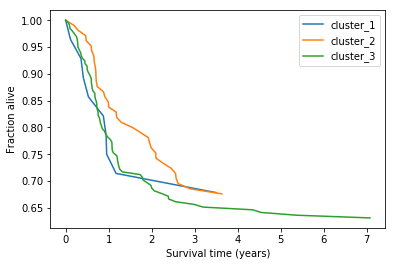

In [43]:
plot_cluster_survival_curves(clusters, data.columns, patients)